In [1]:
import networkx as nx
from networkx.algorithms.community import modularity
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.metrics import normalized_mutual_info_score as NMI
import community as community_louvain
%matplotlib inline

# EU Core Communication

The network was generated using email data from a large European research institution. We have anonymized information about all incoming and outgoing email between members of the research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.

This network represents the "core" of the email-EuAll network, which also contains links between members of the institution and people outside of the institution (although the node IDs are not the same).

In [2]:
g = nx.read_edgelist('email-Eu-core.txt', create_using=nx.MultiDiGraph)
labels = np.loadtxt('email-Eu-core-department-labels.txt')


In [3]:
print(nx.info(g))

MultiDiGraph with 1005 nodes and 25571 edges


This is a medium size graph but I would recommend skipping this step of visualizing it takes too long to display. We also see that there are alot of self loops where universities only communicate with one another

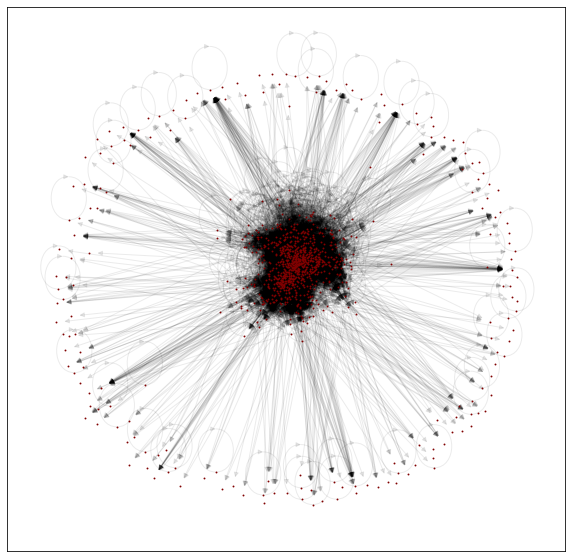

In [4]:
pos=nx.spring_layout(g)
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(g, pos=pos, node_color = 'maroon', node_size = .8)
nx.draw_networkx_edges(g, pos=pos,alpha = .08)
plt.show()

We can use the adjcancy matrix as a visual aid as well. We can see where the edges are concentrated if we start to see small or large blocks

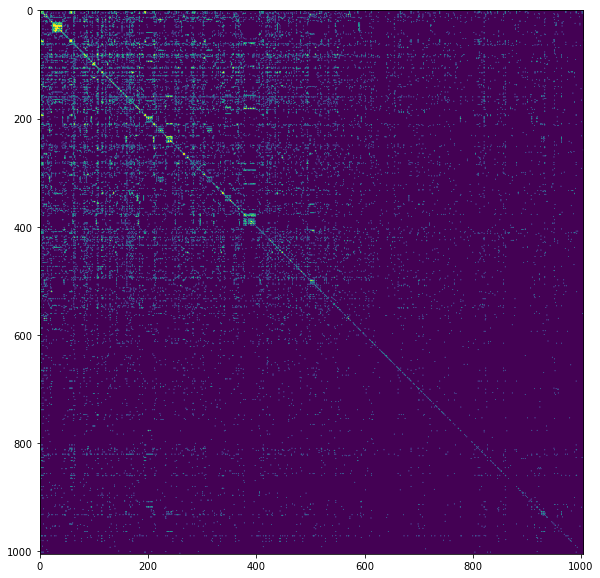

In [5]:
adj = nx.adjacency_matrix(g).todense()
plt.figure(figsize=(10,10))
plt.imshow(adj)
plt.show()

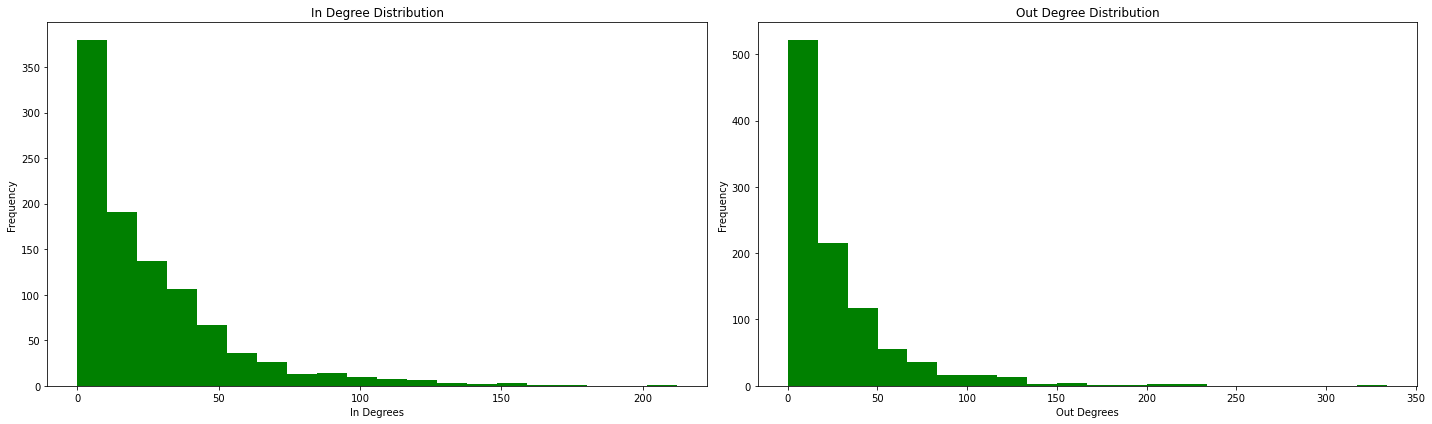

In [6]:
in_node,in_degree = zip(*list(g.in_degree()))
out_node,out_degree = zip(*list(g.out_degree()))
fig, axs = plt.subplots(1,2,figsize=(20,6))
axs[0].hist(in_degree,20,color='green')
axs[0].set_xlabel('In Degrees')
axs[0].set_ylabel('Frequency')
axs[0].set_title('In Degree Distribution')

axs[1].hist(out_degree,20,color='green')
axs[1].set_xlabel('Out Degrees')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Out Degree Distribution')
plt.tight_layout()
plt.show()

Something interesting here is the most highest pagerank nodes doesnt have the most incoming relationships

In [7]:
pr = nx.pagerank(g)
print(f'Top 5 PageRank Papers:\n {sorted(pr.items(), key=lambda x: x[1], reverse=True)[:5]}')

Top 5 PageRank Papers:
 [('1', 0.009411560186382712), ('130', 0.006913890234439256), ('160', 0.006758893760759583), ('62', 0.005322217132261051), ('86', 0.005130048318172175)]


In [8]:
g.in_degree(str([1,130,160,62,86]))

InMultiDegreeView({'1': 51, '3': 62, '0': 32, '6': 93, '2': 77, '8': 34})

Remember the number of eigenvectors you need are a hyperparameter and will be an interative process on finding the right number

In [9]:
embedding = SpectralEmbedding(n_components=11, affinity='precomputed')
vectors = embedding.fit_transform(adj)

C:\Users\asaid002\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
C:\Users\asaid002\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Recommend using tsne to project your eigenvectors to two dimensions to view how well the clusters are forming

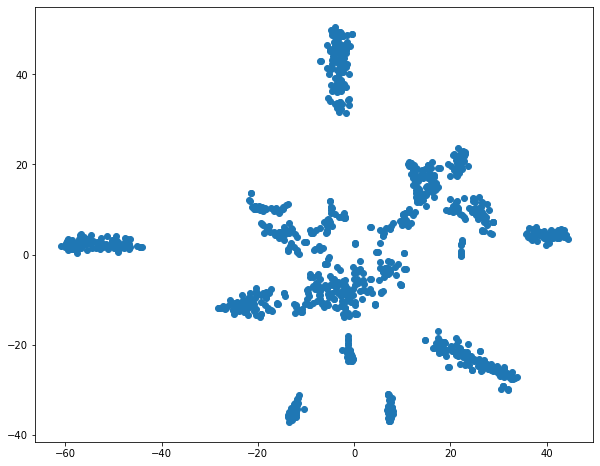

In [10]:
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],

)
plt.show()

In [11]:
def community_dict(nodes, labels = None, community = None):
    if community:
    comm = {}
    for i, v in community.items():
        comm[v] = [i] if v not in comm.keys() else comm[v] + [i]
    return(comm)
    
    elif list(labels):
        comm = {}
        pred = {node:pred for node,pred in zip(nodes, labels)}
        for i, v in pred.items():
            comm[v] = [i] if v not in comm.keys() else comm[v] + [i]
        return(comm)


IndentationError: expected an indented block (Temp/ipykernel_22340/1527476386.py, line 3)

Assuming we dont know how many clusters exists using the elbow technique is a good trick to setting clusters

In [ ]:
inetria = []
x = []
mod = []
for k in range(2,60):
    km = KMeans(n_clusters = k, n_init=10).fit(vectors)
    inetria.append(km.inertia_)
    x.append(k)
    comm = community_dict(nodes = g.nodes(), labels = km.labels_)
    mod.append(modularity(g,comm.values()))
plt.figure(figsize=(10,6))
plt.title('K-Means Elbow')
plt.plot(x, inetria,marker='x')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Modularity')
plt.plot(x, mod,marker='x')
plt.show()


In [ ]:
km = KMeans(n_clusters = 15, n_init=10).fit(vectors)
print(f'Normalized Mutal Information: {NMI(labels[:,1], km.labels_)}')

In [ ]:
km = KMeans(n_clusters = 42, n_init=10).fit(vectors)
comm = community_dict(g.nodes(),km.labels_)
print(f'Normalized Mutal Information: {NMI(labels[:,1], km.labels_)}')
print(f'Modularity: {modularity(g,comm.values(),resolution=.2)}')

In [ ]:
resolution = .2
partition = community_louvain.best_partition(nx.Graph(g), resolution=resolution)
comm = community_dict(nodes = g.nodes(), community=partition)
pred = [i for i in partition.values()]
print(f'Normalized Mutal Information: {NMI(labels[:,1], pred)}')
print(f'Modularity: {modularity(g,comm.values(),resolution=.2)}')
print(f'Number of Communities : {len(comm.values())}')